In [1]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 36.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 43.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.4 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 12.2 MB/s eta 0:00:0000:010:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from src.dispatch.dispatch import NeuralDispatch

: 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from utils import *
from dispatch.dispatch import Dispatch, NeuralDispatch
from simulator.base_simulator import BaseSimulator, ManualSimulator
from simulator.simulator import Simulator
from simulator.graphics import plot_CR, plot_counts
from tqdm import tqdm
import json
from collections import Counter

import torch
from networks.encoders.point_encoder import PointEncoder
# from networks.scoring_v1 import ScoringNet, ScoringInterface

from collections import defaultdict
import matplotlib.pyplot as plt
import torch


from objects.point import Point
from networks.scoring_networks.net1 import ScoringNet
from networks.encoders.gamble_encoder import GambleTripleEncoder
# from networks.utils import get_assignments_by_scores

from joblib import Parallel, delayed
# import importlib
# importlib.reload(networks)

In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [5]:
with open('configs/network_hyperparams.json') as f:
    hyperparams = json.load(f)    

net = ScoringNet(
    n_layers=hyperparams['n_layers'],
    d_model=hyperparams['d_model'],
    n_head=hyperparams['n_head'],
    dim_ff=hyperparams['dim_ff'],
    device=device,
    path_weights='pretrained_models/eta_scoring_1/eta_scoring_1.pt'
)

# point_encoder = PointEncoder(point_enc_dim=hyperparams['point_enc_dim'], device=device)
# point_encoder.load_state_dict(torch.load('pretrained_models/point_encoder64/point_encoder64.pt', map_location=device))

encoder = GambleTripleEncoder(
    number_enc_dim=hyperparams['number_enc_dim'], 
    d_model=hyperparams['d_model'], 
    point_enc_dim=hyperparams['point_enc_dim'],
    path_weights='pretrained_models/assignment_cloning_model_v2/encoders/',
    # point_encoder=point_encoder,
    device=device
)

bounds = (Point(0, 0), Point(10, 10))
# model = ScoringInterface(net)
# model.load_weights('pretrained_models/assignment_cloning_model_v2')

net weights loaded successfuly!
gamble encoder weights loaded successfuly!


## Pretraining

In [6]:
from networks.utils import (
    get_target_assignments,
    get_batch_embeddings_tensors,
    get_batch_masks,
    cross_entropy_assignment_loss,
    get_cross_mask
)
from utils import get_batch_quality_metrics, get_CR, update_assignment_accuracy_statistics
from networks.utils import get_assignments_by_scores

with open('configs/training_settings.json') as f:
    training_settings = json.load(f)

dsp = NeuralDispatch(net, encoder)
get_CR(get_batch_quality_metrics(dsp, Simulator, 1, 100))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


0.12154696132596685

In [5]:
wandb.init(
    project="delivery-RL", 
    name=f"increase_max_items", 
    config={
        'hyperparams': hyperparams,
        'training_settings': training_settings,
        'device': device,
    })

In [14]:
c = Counter()
num_epochs = training_settings['num_epochs']
num_iters = training_settings['num_iters_in_epoch']
batch_size = training_settings['batch_size']

optimizer = torch.optim.SGD(net.parameters(), lr=training_settings['lr'], momentum=training_settings['momentum'])
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=n_iters)
scheduler = None

def apply_next_to_simulator(idx, simulators, assignments):
    simulators[idx].Next(assignments[idx])

for epoch in tqdm(range(num_epochs)):
    net.train()
    encoder.train()
    simulators = [Simulator() for i in range(batch_size)]
    for iter in range(num_iters):
        triples = [sim.GetState() for sim in simulators]

        # triples = [random_triple(bounds, max_items=20) for _ in range(batch_size)]
        max_num_ords = max([len(triple.orders) for triple in triples])
        max_num_crrs = max([len(triple.couriers) for triple in triples])

        target_assignment_idxs = []
        embeds = []
        ids = []
        for triple in triples:
            target_assignment_idxs.append(get_target_assignments(triple, max_num_ords, max_num_crrs))
            current_embeds, current_ids = encoder(triple, 0)
            embeds.append(current_embeds)
            ids.append(current_ids)

        batch_embs = get_batch_embeddings_tensors(embeds)
        batch_masks = get_batch_masks(triples, device=device)

        optimizer.zero_grad()
        pred_scores, _ = net(batch_embs, batch_masks)

        # if iter > 20:
            # print('gamble info:\n')
            # for enum, triple in enumerate(triples):
            #     print(f'triple number {enum}:\n', triple)
            #     print('tgt_ass:', target_assignment_idxs[enum])
            #     print('pred_assignments\n', pred_scores[enum, 1:, 1:].argmax(dim=-1))
            # print('pred_scores\n', pred_scores)
            # print(pred_scores.shape)
            # print('tgt_assignments\n', target_assignment_idxs)
        # print('masks\n', get_cross_mask(batch_masks))

        # gradient step
        loss = cross_entropy_assignment_loss(pred_scores, target_assignment_idxs, get_cross_mask(batch_masks))
        loss.backward()
        optimizer.step()

        # interraction
        assignments_batch = get_assignments_by_scores(pred_scores, batch_masks, ids)
        Parallel(n_jobs=-1)(delayed(apply_next_to_simulator)(i, simulators, assignments_batch) for i in range(batch_size))
        # for i in range(batch_size):
        #     simulators[i].Next(assignments_batch[i])
            
        # get accuracy statistics
        for batch_idx in range(batch_size):
            update_assignment_accuracy_statistics(target_assignment_idxs[batch_idx], pred_scores[batch_idx], c)
        
        wandb.log({"loss": loss.item()})

    dsp = NeuralDispatch(net, encoder)
    cr = get_CR(get_batch_quality_metrics(dsp, Simulator, batch_size=training_settings['eval_batch_size'], num_steps=training_settings['eval_num_steps']))
    print(cr)
    wandb.log({'cr': cr})

wandb.finish()

  0%|          | 0/100 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [21]:
print(c['fake_mistake_not_assigns'] + c['fake_mistake_assigns'] + c['real_mistakes'] + c['correct'])
print(c)

160
Counter({'not_masked_couriers': 160, 'correct': 152, 'fake_mistake_assigns': 7, 'fake_mistake_not_assigns': 1, 'masked_assigns': 0, 'real_mistakes': 0})


100%|██████████| 100/100 [00:00<00:00, 2848.98it/s]


micro average CR:  0.7616067567623884
macro average CR:  0.7129616821137087


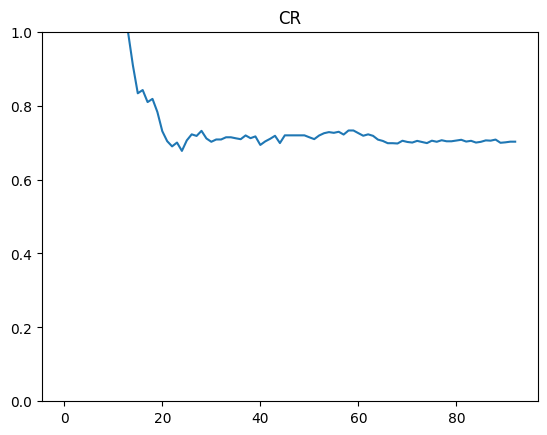

average free couriers:  2.23
average free orders:  11.94
average active routes:  17.77


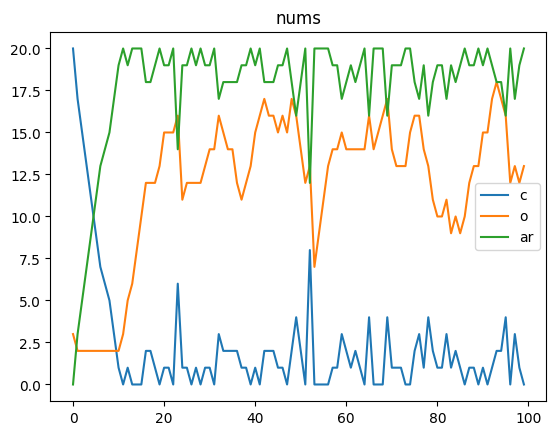

0.7023809523809523


In [32]:
# dsp = NeuralDispatch(net)
dsp = Dispatch()
sim = Simulator()

all_metrics = []
for i in tqdm(range(100)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    state = sim.GetState()
    sim.Next(dsp(state))

plot_CR(all_metrics)
plot_counts(all_metrics)
print(get_CR([all_metrics]))

## RL field 

In [7]:
from reinforcement.simulator_environment import SimulatorEnv
from reinforcement.custom_GAE import CustomGAE
from simulator.simulator import Simulator
from torchrl.envs.utils import check_env_specs
from tensordict.nn import TensorDictModule
from torch.distributions.categorical import Categorical
from torchrl.modules import ProbabilisticActor
from torchrl.collectors import SyncDataCollector
from torchrl.data import ReplayBuffer, LazyTensorStorage
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.objectives import ClipPPOLoss
import json
import time

with open('configs/rl_settings.json') as f:
    rl_settings = json.load(f)
    
my_env = SimulatorEnv(Simulator)

check_env_specs(my_env)

rollout = my_env.rollout(10)
print("rollout of three steps:", rollout.flatten_keys('.'))
print("Shape of the rollout TensorDict:", rollout.batch_size)
rollout.batch_size

check_env_specs succeeded!
rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next.done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next.observation.ids.ar: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.c: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.o: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.masks.ar: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        next.observation.masks.c: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        next.observation.masks.o: Ten

torch.Size([10])

In [8]:
module = TensorDictModule(
    net, in_keys=[('observation', 'tensors'), ('observation', 'masks')], out_keys=['logits', 'state_value']
)

policy_module_actor = ProbabilisticActor(
    module=module,
    in_keys=["logits"],
    distribution_class=Categorical,
    return_log_prob=True,
)

collector = SyncDataCollector(
    my_env,
    policy_module_actor,
    frames_per_batch=rl_settings['frames_per_epoch'],
    total_frames=rl_settings['total_frames'],
    split_trajs=False,
    device=device,
)

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(rl_settings['frames_per_epoch']),
    sampler=SamplerWithoutReplacement(),
    batch_size=rl_settings['batch_size']
)

advantage_module = CustomGAE(
    gamma=rl_settings['gamma'], lmbda=rl_settings['lmbda'], value_network=module, average_gae=True, value_key='state_value'
)

loss_module = ClipPPOLoss(
    actor=policy_module_actor,
    critic=policy_module_actor,
    advantage_key="advantage",
    clip_epsilon=rl_settings['clip_epsilon'],
    entropy_bonus=bool(rl_settings['entropy_eps']),
    entropy_coef=rl_settings['entropy_eps'],
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [ ]:
wandb.init(
    project="delivery-RL", 
    name=f"increase_max_items", 
    config={
        'hyperparams': hyperparams,
        'training_settings': training_settings,
        'device': device,
        }
    )

In [21]:
optim = torch.optim.Adam(list(loss_module.parameters()) + list(encoder.parameters()), lr=rl_settings['lr'])
pbar = tqdm(total=rl_settings['total_frames'])

start_outer = time.time()
for i, tensordict_data in enumerate(collector):
    start_inner = time.time()
    print(f'outer time: {start_inner - start_outer}', end='')
    for _ in range(rl_settings['num_epochs']):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(rl_settings['frames_per_epoch'] // rl_settings['batch_size']):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), rl_settings['max_grad_norm'])
            optim.step()
            optim.zero_grad()
            wandb.log({
                "loss_total": loss_value.item(),
                'loss_objective': loss_vals['loss_objective'],
                'loss_critic': loss_vals['loss_critic'],
                'loss_entropy': loss_vals['loss_entropy']
                })
            
    dsp = NeuralDispatch(net, encoder)
    cr = get_CR(get_batch_quality_metrics(dsp, Simulator, batch_size=training_settings['eval_batch_size'], num_steps=training_settings['eval_num_steps']))
    wandb.log({'cr': cr})
    
    start_outer = time.time()
    print(f'inner time: {start_outer - start_inner}', end='\n')    

wandb.finish()

  0%|          | 0/64000 [03:19<?, ?it/s]


outer time: 1.6035079956054688inner time: 15.709347009658813
outer time: 1.3045949935913086inner time: 20.968085050582886
outer time: 1.4153859615325928inner time: 21.76977801322937
outer time: 1.396456003189087

KeyboardInterrupt: 

## Testing RL

In [8]:
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
import torch.nn.functional as F
from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector, MultiSyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from torchrl.envs import EnvBase
from tensordict.tensordict import TensorDictBase, TensorDict
from typing import Optional
import gym
from torchrl.data import CompositeSpec, BoundedTensorSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, OneHotDiscreteTensorSpec, DiscreteTensorSpec, UnboundedDiscreteTensorSpec


class SimulatorEnv(EnvBase):
    def __init__(self, simulator: type[Simulator], seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[])

        self.load_settings()
        
        # self.simulators = [simulator(seed=i) for i in range(sub_batch_size)]
        self.simulator = simulator()
        self.encoder = GambleTripleEncoder(number_enc_dim=self.number_enc_dim, d_model=self.d_model, point_enc_dim=self.point_enc_dim)
        # self.model = ScoringInterface(net)
        # triples = [simulator.GetState() for simulator in self.simulators]
        # self.model.encode_input(triples, 0)
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)

    def load_settings(self):
        with open('configs/rl_settings.json') as f:
            settings = json.load(f)
        self.max_num_orders = settings['max_num_orders']
        self.max_num_couriers = settings['max_num_couriers']
        self.max_num_active_routes = settings['max_num_active_routes']

        with open('configs/network_hyperparams.json') as f:
            hyperparams = json.load(f)
        self.number_enc_dim = hyperparams['number_enc_dim']
        self.d_model = hyperparams['d_model']
        self.point_enc_dim = hyperparams['point_enc_dim']


    def make_masks(self, tensors):
        masks = {
            'o': torch.tensor([True] + [False] * (len(tensors['o']) - 1), device=device, dtype=torch.bool),
            'c': torch.tensor([True] + [False] * (len(tensors['c']) - 1), device=device, dtype=torch.bool),
            'ar': torch.tensor([True] + [False] * (len(tensors['ar']) - 1), device=device, dtype=torch.bool)
        }

        return masks
    
    def pad_tensors(self, tensors, masks, ids):
        '''
        Pads tensors to max_limits inplace
        '''
        max_limits = {
            'o': self.max_num_orders,
            'c': self.max_num_couriers,
            'ar': self.max_num_active_routes
        }
        for item_type in ['o', 'c', 'ar']:
            length = tensors[item_type].shape[0]
            tensors[item_type] = F.pad(input=tensors[item_type], pad=(0, 0, 0, max_limits[item_type] - length), mode='constant', value=0.0)
            masks[item_type] = F.pad(input=masks[item_type], pad=(0, max_limits[item_type] - length), mode='constant', value=True)
            ids[item_type] = F.pad(input=ids[item_type], pad=(0, max_limits[item_type] - length), mode='constant', value=-1)

        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        '''
        tensordict['action'] - a np.array of indexes (not IDs) of couriers assigned for the given order. If there is no courier assigned self.max_num_couriers is provided.
        BOS-fake items are included.
        '''

        assignments = []
        assigned_o_idxs = set()
        assigned_c_idxs = set()
        for o_idx, c_idx in enumerate(tensordict['action'].numpy()):
            if c_idx != self.max_num_couriers  \
                and not tensordict['observation', 'masks', 'o'][o_idx] \
                and not tensordict['observation', 'masks', 'c'][c_idx] \
                and (o_idx not in assigned_o_idxs) and (c_idx not in assigned_c_idxs) \
            :
                assignment = (tensordict['observation', 'ids', 'o'][o_idx].item(), tensordict['observation', 'ids', 'c'][c_idx].item())
                assignments.append(assignment)
                assigned_o_idxs.add(o_idx)
                assigned_c_idxs.add(c_idx)

        # print(assignments)
        # print(self.simulator.GetState())
        self.simulator.Next(assignments)
        triple = self.simulator.GetState()
        tensors, ids = self.encoder(triple, 0)
        masks = self.make_masks(tensors)
        self.pad_tensors(tensors, masks, ids)

        out = TensorDict(
            {
                "next": {
                    "observation": {
                        'tensors': {
                            'o': tensors['o'],
                            'c': tensors['c'],
                            'ar': tensors['ar']     
                        },
                        'masks': {
                            'o': masks['o'],
                            'c': masks['c'],
                            'ar': masks['ar']     
                        },
                        'ids': {
                            'o': ids['o'],
                            'c': ids['c'],
                            'ar': ids['ar']
                        }
                    },
                    "reward": torch.tensor(0, dtype=torch.float32),
                    "done": torch.tensor(False, dtype=torch.bool),
                    # "reward": torch.tensor([0] * sub_batch_size, dtype=torch.float32),
                    # "done": torch.tensor([False] * sub_batch_size, dtype=torch.bool),
                }
            },
            tensordict.shape
            # batch_size=tensordict.shape[0]
        )
        # print(out['next', 'observation', 'ids', 'o'])
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            triple = self.simulator.GetState()
            tensors, ids = self.encoder(triple, 0)
            masks = self.make_masks(tensors)
            self.pad_tensors(tensors, masks, ids)
            
            return TensorDict(
            {
                "observation": {
                    'tensors': {
                        'o': tensors['o'],
                        'c': tensors['c'],
                        'ar': tensors['ar']     
                    },
                    'masks': {
                        'o': masks['o'],
                        'c': masks['c'],
                        'ar': masks['ar']     
                    },
                    'ids': {
                        'o': ids['o'],
                        'c': ids['c'],
                        'ar': ids['ar']
                    }
                }
            },
            # batch_size=[sub_batch_size]
            batch_size=self.batch_size
        ) 
        return tensordict
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = DiscreteTensorSpec(
            n=self.max_num_couriers + 1,
            dtype=torch.int,
            shape=[self.max_num_orders]
        )
        observation_spec = CompositeSpec(
            tensors = CompositeSpec(
                o = UnboundedContinuousTensorSpec(
                    shape=[self.max_num_orders, self.encoder.d_model],
                    dtype=torch.float
                ),
                c = UnboundedContinuousTensorSpec(
                    shape=[self.max_num_couriers, self.encoder.d_model],
                    dtype=torch.float
                ),
                ar = UnboundedContinuousTensorSpec(
                    shape=[self.max_num_active_routes, self.encoder.d_model],
                    dtype=torch.float
                ),
                # shape=[sub_batch_size]
            ),
            masks = CompositeSpec(
                o = DiscreteTensorSpec(
                    n=2,
                    dtype=torch.bool,
                    shape=[self.max_num_orders]
                ),
                c = DiscreteTensorSpec(
                    n=2,
                    dtype=torch.bool,
                    shape=[self.max_num_couriers]
                ),
                ar = DiscreteTensorSpec(
                    n=2,
                    dtype=torch.bool,
                    shape=[self.max_num_active_routes]
                ),
                # shape=[sub_batch_size]
            ),
            ids = CompositeSpec(
                o = UnboundedDiscreteTensorSpec(
                    dtype=torch.int,
                    shape=[self.max_num_orders]
                ),
                c = UnboundedDiscreteTensorSpec(
                    dtype=torch.int,
                    shape=[self.max_num_couriers]
                ),
                ar = UnboundedDiscreteTensorSpec(
                    dtype=torch.int,
                    shape=[self.max_num_active_routes]
                ),
                # shape=[sub_batch_size]
            ), 
            # shape=[sub_batch_size]
        )
        # if not isinstance(observation_spec, CompositeSpec):
        observation_spec = CompositeSpec(observation=observation_spec) # shape=[sub_batch_size]
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            # shape=[sub_batch_size],
            shape=[1],
            dtype=torch.float32,
        )
        self.done_spec = BinaryDiscreteTensorSpec(
            # n=sub_batch_size,
            # shape=[sub_batch_size],
            n=1,
            shape=[1],
            dtype=torch.bool
        )
 

In [9]:
my_env = SimulatorEnv(Simulator)

In [7]:
# env = TransformedEnv(
#     my_env,
    # Compose(
    #     # normalize observations
    #     # ObservationNorm(in_keys=["observation"]),
    #     # DoubleToFloat(in_keys=["observation"]),
    #     StepCounter(),
    # ),
# )

In [8]:
# env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
# print("normalization constant shape:", env.transform[0].loc.shape)
print("observation_spec:", my_env.observation_spec)
print("reward_spec:", my_env.reward_spec)
print("input_spec:", my_env.input_spec)
print("action_spec (as defined by input_spec):", my_env.action_spec)

observation_spec: CompositeSpec(
    observation: CompositeSpec(
        tensors: CompositeSpec(
            o: UnboundedContinuousTensorSpec(
                 shape=torch.Size([100, 512]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
            c: UnboundedContinuousTensorSpec(
                 shape=torch.Size([100, 512]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
            ar: UnboundedContinuousTensorSpec(
                 shape=torch.Size([100, 512]), space=None, device=cpu, dtype=torch.float32, domain=continuous), device=cpu, shape=torch.Size([])),
        masks: CompositeSpec(
            o: DiscreteTensorSpec(
                 shape=torch.Size([100]), space=DiscreteBox(n=2), device=cpu, dtype=torch.bool, domain=discrete),
            c: DiscreteTensorSpec(
                 shape=torch.Size([100]), space=DiscreteBox(n=2), device=cpu, dtype=torch.bool, domain=discrete),
            ar: DiscreteTensorSpec(
                 shape=torch.

In [9]:
check_env_specs(my_env)

check_env_specs succeeded!


In [149]:
rollout = my_env.rollout(10)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)
rollout.batch_size

In [49]:
module = TensorDictModule(
    net, in_keys=[('observation', 'tensors'), ('observation', 'masks')], out_keys=['logits', 'state_value']
)

In [50]:
# td = my_env.reset()
# net(td['observation', 'tensors'].to_dict(), td['observation', 'masks'].to_dict())
# td['observation', 'tensors'].to_dict()

In [51]:
print("Running policy:", module(my_env.reset()).flatten_keys('.'))
# env.reset()

Running policy: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([100, 101]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.ids.ar: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.int32, is_shared=False),
        observation.ids.c: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.int32, is_shared=False),
        observation.ids.o: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.int32, is_shared=False),
        observation.masks.ar: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.bool, is_shared=False),
        observation.masks.c: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.bool, is_shared=False),
        observation.masks.o: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.bool, is_shared=False),
        observation.tensors.ar: Tensor(shape=torch.Size([100, 512]), device=cpu, dtype=torch.float32, is_share

In [52]:
from typing import Optional, Sequence, Union
from tensordict.tensordict import TensorDictBase
from torchrl.data.tensor_specs import TensorSpec
from torchrl.modules.tensordict_module.common import SafeModule


class ProbabilisticActorPolivyAvg(ProbabilisticActor):
    def __init__(self, module: SafeModule, in_keys: str | Sequence[str], out_keys: Sequence[str] | None = None, spec: TensorSpec | None = None, **kwargs):
        super().__init__(module, in_keys, out_keys, spec, **kwargs)
    
    def forward(self, tensordict: TensorDictBase, tensordict_out: TensorDictBase | None = None, **kwargs) -> TensorDictBase:
        tens = super().forward(tensordict, tensordict_out, **kwargs)
        input = tens['sample_log_prob']
        mask = tens['observation', 'masks', 'o']

        assert (len(input.shape) == 2 and len(mask.shape) == 2) or (len(input.shape) == 1 and len(mask.shape) == 1), 'dims should be [bs, ord] or [ord]'

        sums = torch.sum(torch.where(mask, input, 0), dim=-1)
        nums = torch.sum(torch.where(mask, 1, 0), dim=-1)

        tens['sample_log_prob'] = torch.where(nums > 0, sums / nums, 0)

        return tens


In [77]:
# from tensordict.nn.distributions import Categorical
from torch.distributions.categorical import Categorical
policy_module_actor = ProbabilisticActor(
    module=module,
    in_keys=["logits"],
    distribution_class=Categorical,
    # distribution_kwargs={
    #     "n": env.action_spec.space.n,
    # },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [54]:
# class LogPolicyAvg(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, input, mask):
#         assert (len(input.shape) == 2 and len(mask.shape) == 2) or (len(input.shape) == 1 and len(mask.shape) == 1), 'dims should be [bs, ord] or [ord]'

#         sums = torch.sum(torch.where(mask, input, 0), dim=-1)
#         nums = torch.sum(torch.where(mask, 1, 0), dim=-1)

#         return torch.where(nums > 0, sums / nums, 0)

In [55]:
# from tensordict.nn import TensorDictModule, TensorDictSequential
# final_module = TensorDictSequential(
#     policy_module_actor,
#     TensorDictModule(LogPolicyAvg(), in_keys=['sample_log_prob', ('observation', 'masks', 'o')], out_keys=['sample_log_prob']),
# )


In [56]:
# value_module = ValueOperator(
#     module=net,
#     in_keys=[('observation', 'tensors'), ('observation', 'masks')], 
#     out_keys=['logits', 'values']
# )

In [136]:
collector = SyncDataCollector(
    my_env,
    policy_module_actor,
    frames_per_batch=1,
    total_frames=5,
    split_trajs=False,
    device=device,
)

In [79]:
for i, c in enumerate(collector):
    if i == 3:
        break
c.flatten_keys('.')

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 100]), device=cpu, dtype=torch.int64, is_shared=False),
        collector.traj_ids: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([1, 100, 101]), device=cpu, dtype=torch.float32, is_shared=False),
        next.done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next.observation.ids.ar: Tensor(shape=torch.Size([1, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.c: Tensor(shape=torch.Size([1, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.o: Tensor(shape=torch.Size([1, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.masks.ar: Tensor(shape=torch.Size([1, 100]), device=cpu, dtype=torch.bool, is_shared=False),

In [137]:
from torchrl.objectives.ppo import PPOLoss
from torchrl.objectives.utils import hold_out_net
from torchrl.envs.utils import step_mdp
from typing import Union, Tuple, List
from torchrl.modules import SafeModule
from torchrl.objectives.value.utils import _custom_conv1d, _make_gammas_tensor

class CustomGAE(nn.Module):
    def __init__(
        self,
        gamma: Union[float, torch.Tensor],
        lmbda: float,
        value_network: SafeModule,
        average_gae: bool = False,
        differentiable: bool = False,
        advantage_key: Union[str, Tuple] = "advantage",
        value_target_key: Union[str, Tuple] = "value_target",
        value_key: Union[str, Tuple] = "state_value",
    ):
        super().__init__()
        try:
            device = next(value_network.parameters()).device
        except StopIteration:
            device = torch.device("cpu")
        self.register_buffer("gamma", torch.tensor(gamma, device=device))
        self.register_buffer("lmbda", torch.tensor(lmbda, device=device))
        self.value_network = value_network
        self.value_key = value_key
        if value_key not in value_network.out_keys:
            raise KeyError(
                f"value key '{value_key}' not found in value network out_keys."
            )

        self.average_gae = average_gae
        self.differentiable = differentiable

        self.advantage_key = advantage_key
        self.value_target_key = value_target_key

        self.in_keys = (
            value_network.in_keys
            + [("next", "reward"), ("next", "done")]
            + [("next", in_key) for in_key in value_network.in_keys]
        )
        self.out_keys = [self.advantage_key, self.value_target_key]

    @property
    def is_functional(self):
        return (
            "_is_stateless" in self.value_network.__dict__
            and self.value_network.__dict__["_is_stateless"]
        )

    def forward(
        self,
        tensordict: TensorDictBase,
        *unused_args,
        params: Optional[List[torch.Tensor]] = None,
        target_params: Optional[List[torch.Tensor]] = None,
    ) -> TensorDictBase:
        if tensordict.batch_dims < 1:
            raise RuntimeError(
                "Expected input tensordict to have at least one dimensions, got"
                f"tensordict.batch_size = {tensordict.batch_size}"
            )
        reward = tensordict.get(("next", "reward"))
        gamma, lmbda = self.gamma, self.lmbda
        kwargs = {}
        if self.is_functional and params is None:
            raise RuntimeError(
                "Expected params to be passed to advantage module but got none."
            )
        if params is not None:
            kwargs["params"] = params
        with hold_out_net(self.value_network):
            # we may still need to pass gradient, but we don't want to assign grads to
            # value net params
            self.value_network(tensordict, **kwargs)

        value = tensordict.get(self.value_key)

        step_td = step_mdp(tensordict)
        if target_params is not None:
            # we assume that target parameters are not differentiable
            kwargs["params"] = target_params
        elif "params" in kwargs:
            kwargs["params"] = kwargs["params"].detach()
        with hold_out_net(self.value_network):
            # we may still need to pass gradient, but we don't want to assign grads to
            # value net params
            self.value_network(step_td, **kwargs)
        next_value = step_td.get(self.value_key)
        done = tensordict.get(("next", "done"))
               
        adv, value_target = self.vec_generalized_advantage_estimate(
            gamma, lmbda, value, next_value, reward, done
        )

        if self.average_gae:
            loc = adv.mean()
            scale = adv.std().clamp_min(1e-4)
            adv = adv - loc
            adv = adv / scale

        tensordict.set(self.advantage_key, adv)
        tensordict.set(self.value_target_key, value_target)

        return tensordict
    
    def vec_generalized_advantage_estimate(self, 
        gamma: float,
        lmbda: float,
        state_value: torch.Tensor, # [*bs, ts, 100]
        next_state_value: torch.Tensor, # [*bs, ts, 100]
        reward: torch.Tensor, # [*bs, ts, 1]
        done: torch.Tensor, # [*bs, ts, 1]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Get generalized advantage estimate of a trajectory.

        Refer to "HIGH-DIMENSIONAL CONTINUOUS CONTROL USING GENERALIZED ADVANTAGE ESTIMATION"
        https://arxiv.org/pdf/1506.02438.pdf for more context.

        Args:
            gamma (scalar): exponential mean discount.
            lmbda (scalar): trajectory discount.
            state_value (Tensor): value function result with old_state input.
                must be a [Batch x TimeSteps x 1] or [Batch x TimeSteps] tensor
            next_state_value (Tensor): value function result with new_state input.
                must be a [Batch x TimeSteps x 1] or [Batch x TimeSteps] tensor
            reward (Tensor): reward of taking actions in the environment.
                must be a [Batch x TimeSteps x 1] or [Batch x TimeSteps] tensor
            done (Tensor): boolean flag for end of episode.

        """
        # for tensor in (next_state_value, state_value, reward, done):
        #     if tensor.shape[-1] != 1:
        #         raise RuntimeError(
        #             "Last dimension of generalized_advantage_estimate inputs must be a singleton dimension."
        #         )
        state_value = state_value.unsqueeze(-3).transpose(-1, -3)
        next_state_value = next_state_value.unsqueeze(-3).transpose(-1, -3)
        reward = reward.unsqueeze(-3).transpose(-1, -3)
        done = done.unsqueeze(-3).transpose(-1, -3)

        dtype = state_value.dtype
        not_done = 1 - done.to(dtype)
        *batch_size, time_steps = not_done.shape[:-1]

        value = gamma * lmbda
        if isinstance(value, torch.Tensor):
            # create tensor while ensuring that gradients are passed
            gammalmbdas = torch.ones_like(state_value) * not_done * value
        else:
            gammalmbdas = torch.full_like(state_value, value) * not_done
        gammalmbdas = _make_gammas_tensor(gammalmbdas, time_steps, True) # in: [*bs, 100, ts, 1]
        gammalmbdas = gammalmbdas.cumprod(-2)
        # first_below_thr = gammalmbdas < 1e-7
        # # if we have multiple gammas, we only want to truncate if _all_ of
        # # the geometric sequences fall below the threshold
        # first_below_thr = first_below_thr.all(axis=0)
        # if first_below_thr.any():
        #     gammalmbdas = gammalmbdas[..., :first_below_thr, :]

        td0 = reward + not_done * gamma * next_state_value - state_value

        if len(batch_size) > 1:
            td0 = td0.flatten(0, len(batch_size) - 1)
        elif not len(batch_size):
            td0 = td0.unsqueeze(0)

        advantage = _custom_conv1d(td0.transpose(-2, -1), gammalmbdas)

        if len(batch_size) > 1:
            advantage = advantage.unflatten(0, batch_size)
        elif not len(batch_size):
            advantage = advantage.squeeze(0)

        advantage = advantage.transpose(-2, -1)
        value_target = advantage + state_value

        value_target = value_target.transpose(-1, -3).squeeze(-3)
        advantage = advantage.transpose(-1, -3).squeeze(-3)

        return advantage.unsqueeze(-1), value_target
        



In [142]:
from torchrl.data import ReplayBuffer, LazyTensorStorage

num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

frame_skip = 1
frames_per_batch = 16 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 200_000 // frame_skip

sub_batch_size = 16  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 2  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
    batch_size=sub_batch_size
)

In [143]:
advantage_module = CustomGAE(
    gamma=gamma, lmbda=lmbda, value_network=module, average_gae=True, value_key='state_value'
)

loss_module = ClipPPOLoss(
    actor=policy_module_actor,
    critic=policy_module_actor,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr=3e-4)

In [144]:
for i, c in enumerate(collector):
    if i == 5:
        break
    advantage_module(c)
    data_view = c.reshape(-1)
    replay_buffer.extend(data_view.cpu())

subdata = replay_buffer.sample()
# advantage_module(subdata).flatten_keys('.')
# loss_vals = loss_module(subdata)
# loss_value = (
#     loss_vals["loss_objective"]
#     + loss_vals["loss_critic"]
#     + loss_vals["loss_entropy"]
# )


In [145]:
subdata.flatten_keys('.')

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([5, 100]), device=cpu, dtype=torch.int64, is_shared=False),
        advantage: Tensor(shape=torch.Size([5, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector.traj_ids: Tensor(shape=torch.Size([5]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([5, 100, 101]), device=cpu, dtype=torch.float32, is_shared=False),
        next.done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next.observation.ids.ar: Tensor(shape=torch.Size([5, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.c: Tensor(shape=torch.Size([5, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.o: Tensor(shape=torch.Size([5, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        n

In [146]:
loss_vals = loss_module(subdata)

In [147]:
loss_vals

TensorDict(
    fields={
        ESS: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        entropy: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        loss_critic: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        loss_entropy: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        loss_objective: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [148]:
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
    break

  0%|          | 0/200000 [00:18<?, ?it/s]


## Testing area

In [19]:
bs = 2

class TestEnv(EnvBase):
    def __init__(self, seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[bs])
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)
        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        '''
        tensordict['action'] - a np.array of indexes of couriers assigned for the given order. If there is no courier assigned -1 is provided.
        '''
        print('next')
        out = TensorDict(
            {
                "next": {
                    "observation": TensorDict({
                        'a': torch.tensor([[-1, -2], [-4, -5]], dtype=torch.float),
                        'b': torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float),
                        },
                        batch_size=[bs]
                    ),
                    "reward": torch.tensor([0] * bs, dtype=torch.float32),
                    "done": torch.tensor([False] * bs, dtype=torch.bool),
                }
            },
            batch_size=[bs]
        )
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            return TensorDict(
            {
                "observation": TensorDict({
                        'a': torch.tensor([[-1, -2], [-4, -5]], dtype=torch.float),
                        'b': torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float),
                        },
                        batch_size=[bs]
                    ),
            },
            batch_size=[bs]
        ) 
        return tensordict
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = UnboundedDiscreteTensorSpec(
            dtype=torch.int,
            shape=[bs]
            # shape=(1,)
            # shape=(self.model.tensors['o'].shape[0],)
        )
        observation_spec = CompositeSpec(
            a = UnboundedContinuousTensorSpec(
                dtype=torch.float32,
                shape=[bs]
            ),
            b = UnboundedContinuousTensorSpec(
                dtype=torch.float32,
                shape=[bs]
            ),
            shape=[bs]
        )
        # if not isinstance(observation_spec, CompositeSpec):
        observation_spec = CompositeSpec(observation=observation_spec, shape=[bs])
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            shape=[bs],
            dtype=torch.float32,
        )
        self.done_spec = BinaryDiscreteTensorSpec(
            bs,
            shape=[bs]
        )
 

In [20]:
env = TransformedEnv(
    TestEnv(),
    # Compose(
    #     # normalize observations
    #     # ObservationNorm(in_keys=["observation"]),
    #     # DoubleToFloat(in_keys=["observation"]),
    #     StepCounter(),
    # ),
)

In [21]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

check_env_specs(env)

observation_spec: CompositeSpec(
    observation: CompositeSpec(
        a: UnboundedContinuousTensorSpec(
             shape=torch.Size([2, 3]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
        b: UnboundedContinuousTensorSpec(
             shape=torch.Size([2, 3]), space=None, device=cpu, dtype=torch.float32, domain=continuous), device=cpu, shape=torch.Size([2, 3])), device=cpu, shape=torch.Size([2]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([2]), space=None, device=cpu, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: UnboundedDiscreteTensorSpec(
         shape=torch.Size([2]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, contiguous=True)), device=cpu, dtype=torch.int32, domain=continuous), device=cpu, shape=torch.Size([2]))
action_spec (as defined by input_spec): UnboundedDis

AssertionError: The dtypes of the real and fake tensordict don't match for key next.done. Got fake=torch.int64 and real=torch.bool.

In [89]:
fake = env.fake_tensordict().flatten_keys(".")
print(fake)

real_tensordict = env.rollout(3, return_contiguous=True).flatten_keys(".")
print(real_tensordict)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        next.done: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        next.observation.a: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        next.observation.b: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        next.reward: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.a: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.b: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=F

In [91]:
fake_tensordict = fake.unsqueeze(real_tensordict.batch_dims - 1).expand(*real_tensordict.shape).to_tensordict()

In [93]:
# real_tensordict.apply(lambda x: torch.zeros_like(x)) == fake_tensordict.apply(lambda x: torch.zeros_like(x))
# fake_tensordict
fake_tensordict

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        next.done: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        next.observation.a: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next.observation.b: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next.reward: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.a: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.b: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2, 3]),
 

In [131]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.f1 = nn.Linear(3, 5)
        self.f2 = nn.Linear(3, 5)

        self.last = nn.Linear(5, 2)
    
    def forward(self, x, y):
        x = self.f1(x)
        y = self.f2(y)

        return self.last(x - y)

In [137]:
x = torch.tensor([[1, 2, 3]], dtype=torch.float)
y = torch.tensor([[1, 2, 3]], dtype=torch.float)
n = Net()
n(x, y)

tensor([[-1.7460, -0.8222]], grad_fn=<AddmmBackward0>)

In [138]:
policy_module = TensorDictModule(
    n, in_keys=[('inp', "x"), ('inp', "y")], out_keys=["out"]
)

In [146]:
# policy_module(x=x, y=y)
inp = TensorDict(
    {
        'inp': TensorDict({
            'x': x,
            'y': y,
        }, batch_size=())
    },
    batch_size=(1, 3)
)

In [140]:
out = policy_module(inp)

In [23]:
out['out']

tensor([1.9481, 0.0790], grad_fn=<AddBackward0>)

In [147]:
inp.shape

torch.Size([1, 3])